# Practice 1
**Autor: Jorge Vázquez Pérez**

## Table of Contents

1. [Develop a quantum algorithm based on gates and circuits](#apartado1)
2. [Characterize the circuit](apartado2)
3. [Run the circuit](apartado3)
4. [Export/import the circuit](apartado4)

In this practice the distributed version of the Quantum Phase Estimation (QPE) algorithm is going to be carried out along with an explanation of its difficulties and details. First of all, before any circuit and algorithm implementation all the necessary imports will be carried out.

In [1]:
import math
import numpy as np

from bitstring import BitArray

# Importing Qiskit
from qiskit import IBMQ, Aer, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Gate

from qiskit.circuit.library import QFT
from qiskit.circuit.library import PhaseGate

## 1. Develop a quantum algorithm based on gates and circuits <a class="anchor" id="apartado1"></a>

First, we are going to develop the normal Quantum Phase Estimation circuit in order to understand the intricacies of this algorithm and, after all the concepts are clear, we are going to explain the distributed version. This version is really similar with the addition of two subcircuits called Cat Entangler and Car Disentangler, which are used in the teleportation protocol utilized in numerous applications in quantum computing, among which distributed quantum computing is found.

### QPE explanation
But first, let's explain what the QPE algorithm is all about. This algorithm, as its own name says, tries to estimates a phase. More specifically, 

> Giving a state $|\psi\rangle$ and a gate $U$ such that $U|\psi\rangle = e^{2\pi i\theta}|\psi\rangle$, QPE tries to estimate the value of $\theta$.

Basically, what the QPE algorithm does is estimate the phase that a specific gate applies to a specific eigenvector. Once we know this, lets construct the circuit and explain what is the purpose of each part. First, we define the quantum and classical registers used by the circuit.

In [2]:
# Definition of the registers and the circuit (n_eval + 1 qubits)
n_eval = 4

qr_eval = QuantumRegister(n_eval, "eval")
qr_state = QuantumRegister(1, "q")
cl_eval = ClassicalRegister(n_eval, "cl_eval")

qr_list = [qr_eval, qr_state]
qpe = QuantumCircuit(*qr_list, cl_eval, name="QPE")

In the previous piece of code we defined the `n_eval` variable, which represents the number of qubits that are going to be evaluated and that, moreover, represent the amount of precision that we aim in guessing the phase. So if the phase is $0.25$, then with `n_eval = 4` the result will be $0.2500$, but if the phase was to be $0.3456734$, then with `n_eval = 4` would lost information of the 
phase. A compromise between computational cost of adding qubits and precision in the phase guessing is always needed.

Now the

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


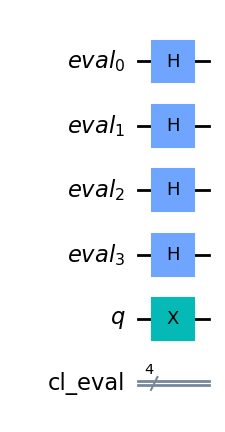

In [3]:
# Declaration of the gates
qpe.x(qr_state[0])
qpe.h(qr_eval)
qpe.draw("mpl")

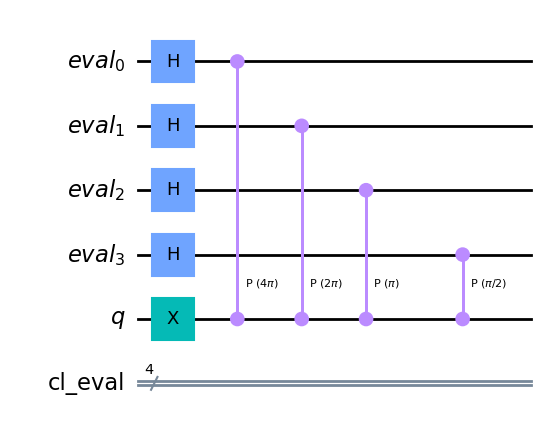

In [4]:
phase_input = 1/4

for j in range(n_eval):
        qpe.append(PhaseGate(theta = 2*math.pi*phase_input).power(2**(n_eval-j-1)).control(), qargs=[j] + qr_state[:])
qpe.draw("mpl")

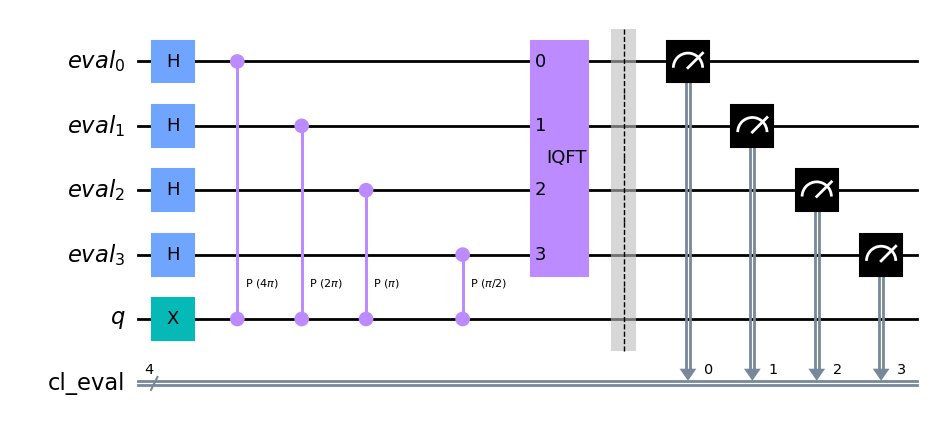

In [5]:
# Add the inverse QFT in both cases and measure the eval qubits  
iqft = QFT(n_eval, inverse=True, do_swaps=False)  
qpe.append(iqft, qargs=qr_eval)
qpe.barrier()
for n in range(n_eval):
    qpe.measure(qr_eval[n],cl_eval[n])

qpe.draw("mpl")

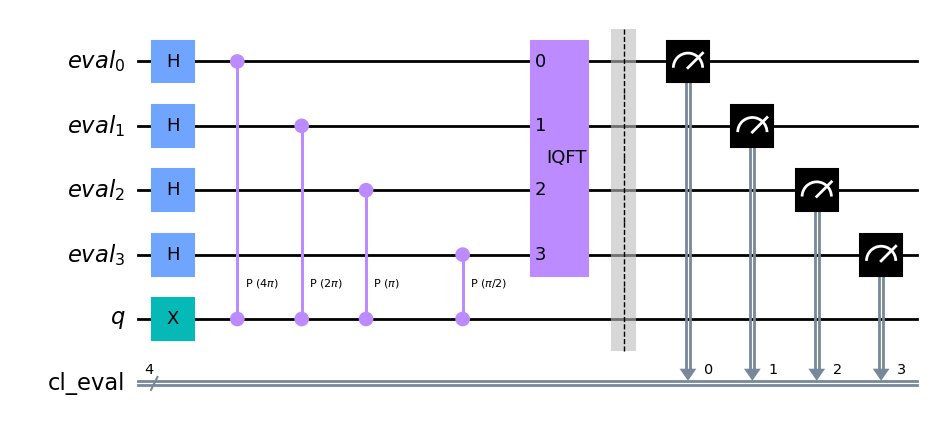

In [6]:
def qpe(gate: Gate = PhaseGate, psi: np.ndarray=[0,1], n_eval: int=4, param: float=0, measurements: bool = True):
    """Usual implementation of QPE algorithm."""

    # Definition of the registers and the circuit (n + 1 qubits)
    qr_eval = QuantumRegister(n_eval, "eval")
    qr_state = QuantumRegister(1, "q")
    cl_eval = ClassicalRegister(n_eval, "cl_eval")
    
    qr_list = [qr_eval, qr_state]
    qpe = QuantumCircuit(*qr_list, cl_eval, name="QPE")
    
    # Declaration of the gates
    qpe.x(qr_state[0])
    qpe.h(qr_eval)
    for j in range(n_eval):
        qpe.append(gate(param).power(2**(n_eval-j-1)).control(), qargs=[j] + qr_state[:])
    
    # Add the inverse QFT in both cases and measure the eval qubits  
    iqft = QFT(n_eval, inverse=True, do_swaps=False)  
    qpe.append(iqft, qargs=qr_eval)
    qpe.barrier()
    if measurements:
        for n in range(n_eval):
            qpe.measure(qr_eval[n],cl_eval[n])
    return qpe

phase_input = 0.25
qpe_circuit = qpe(param = 2*math.pi*phase_input)
qpe_circuit.draw("mpl")

### Distributed version

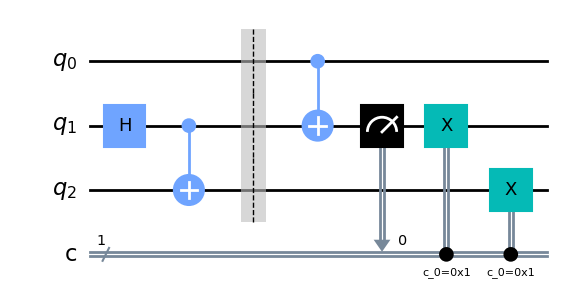

In [7]:
def cat_entangler(num_qubits: int = 3):
    cat_ent = QuantumCircuit(3, 1)
    
    # Create the cat state
    cat_ent.h(1)
    for i_qubit in range(1,num_qubits-1):
        cat_ent.cx(i_qubit, i_qubit+1)
    
    # Execute the teleportation
    cat_ent.barrier()

    cat_ent.cx(0, 1)
    cat_ent.measure(1, 0)
    for i_qubit in range(1,num_qubits):
        cat_ent.x(i_qubit).c_if(0, 1)
    
    return cat_ent

cat_ent = cat_entangler()
cat_ent.draw("mpl")

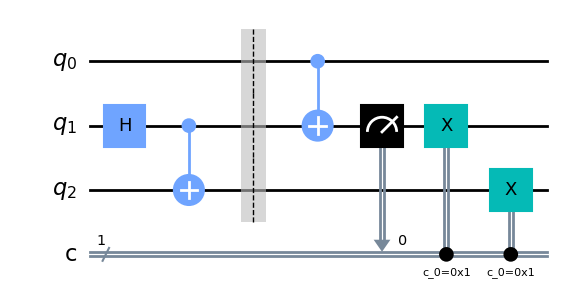

In [8]:
def cat_disentangler(num_qubits: int = 3):
    cat_ent = QuantumCircuit(3, 1)
    
    # Create the cat state
    cat_ent.barrier()
    for i_qubit in range(2,num_qubits):
        cat_ent.h(i_qubit)

    for i_qubit, j_clbit in zip(range(2, num_qubits), range(num_qubits-2)):
        cat_ent.measure(i_qubit, j_clbit)
        cat_ent.x(i_qubit).c_if(j_clbit, 1)
        cat_ent.z(0).c_if(j_clbit, 1)
    
    return cat_ent

cat_ent = cat_entangler()
cat_ent.draw("mpl")


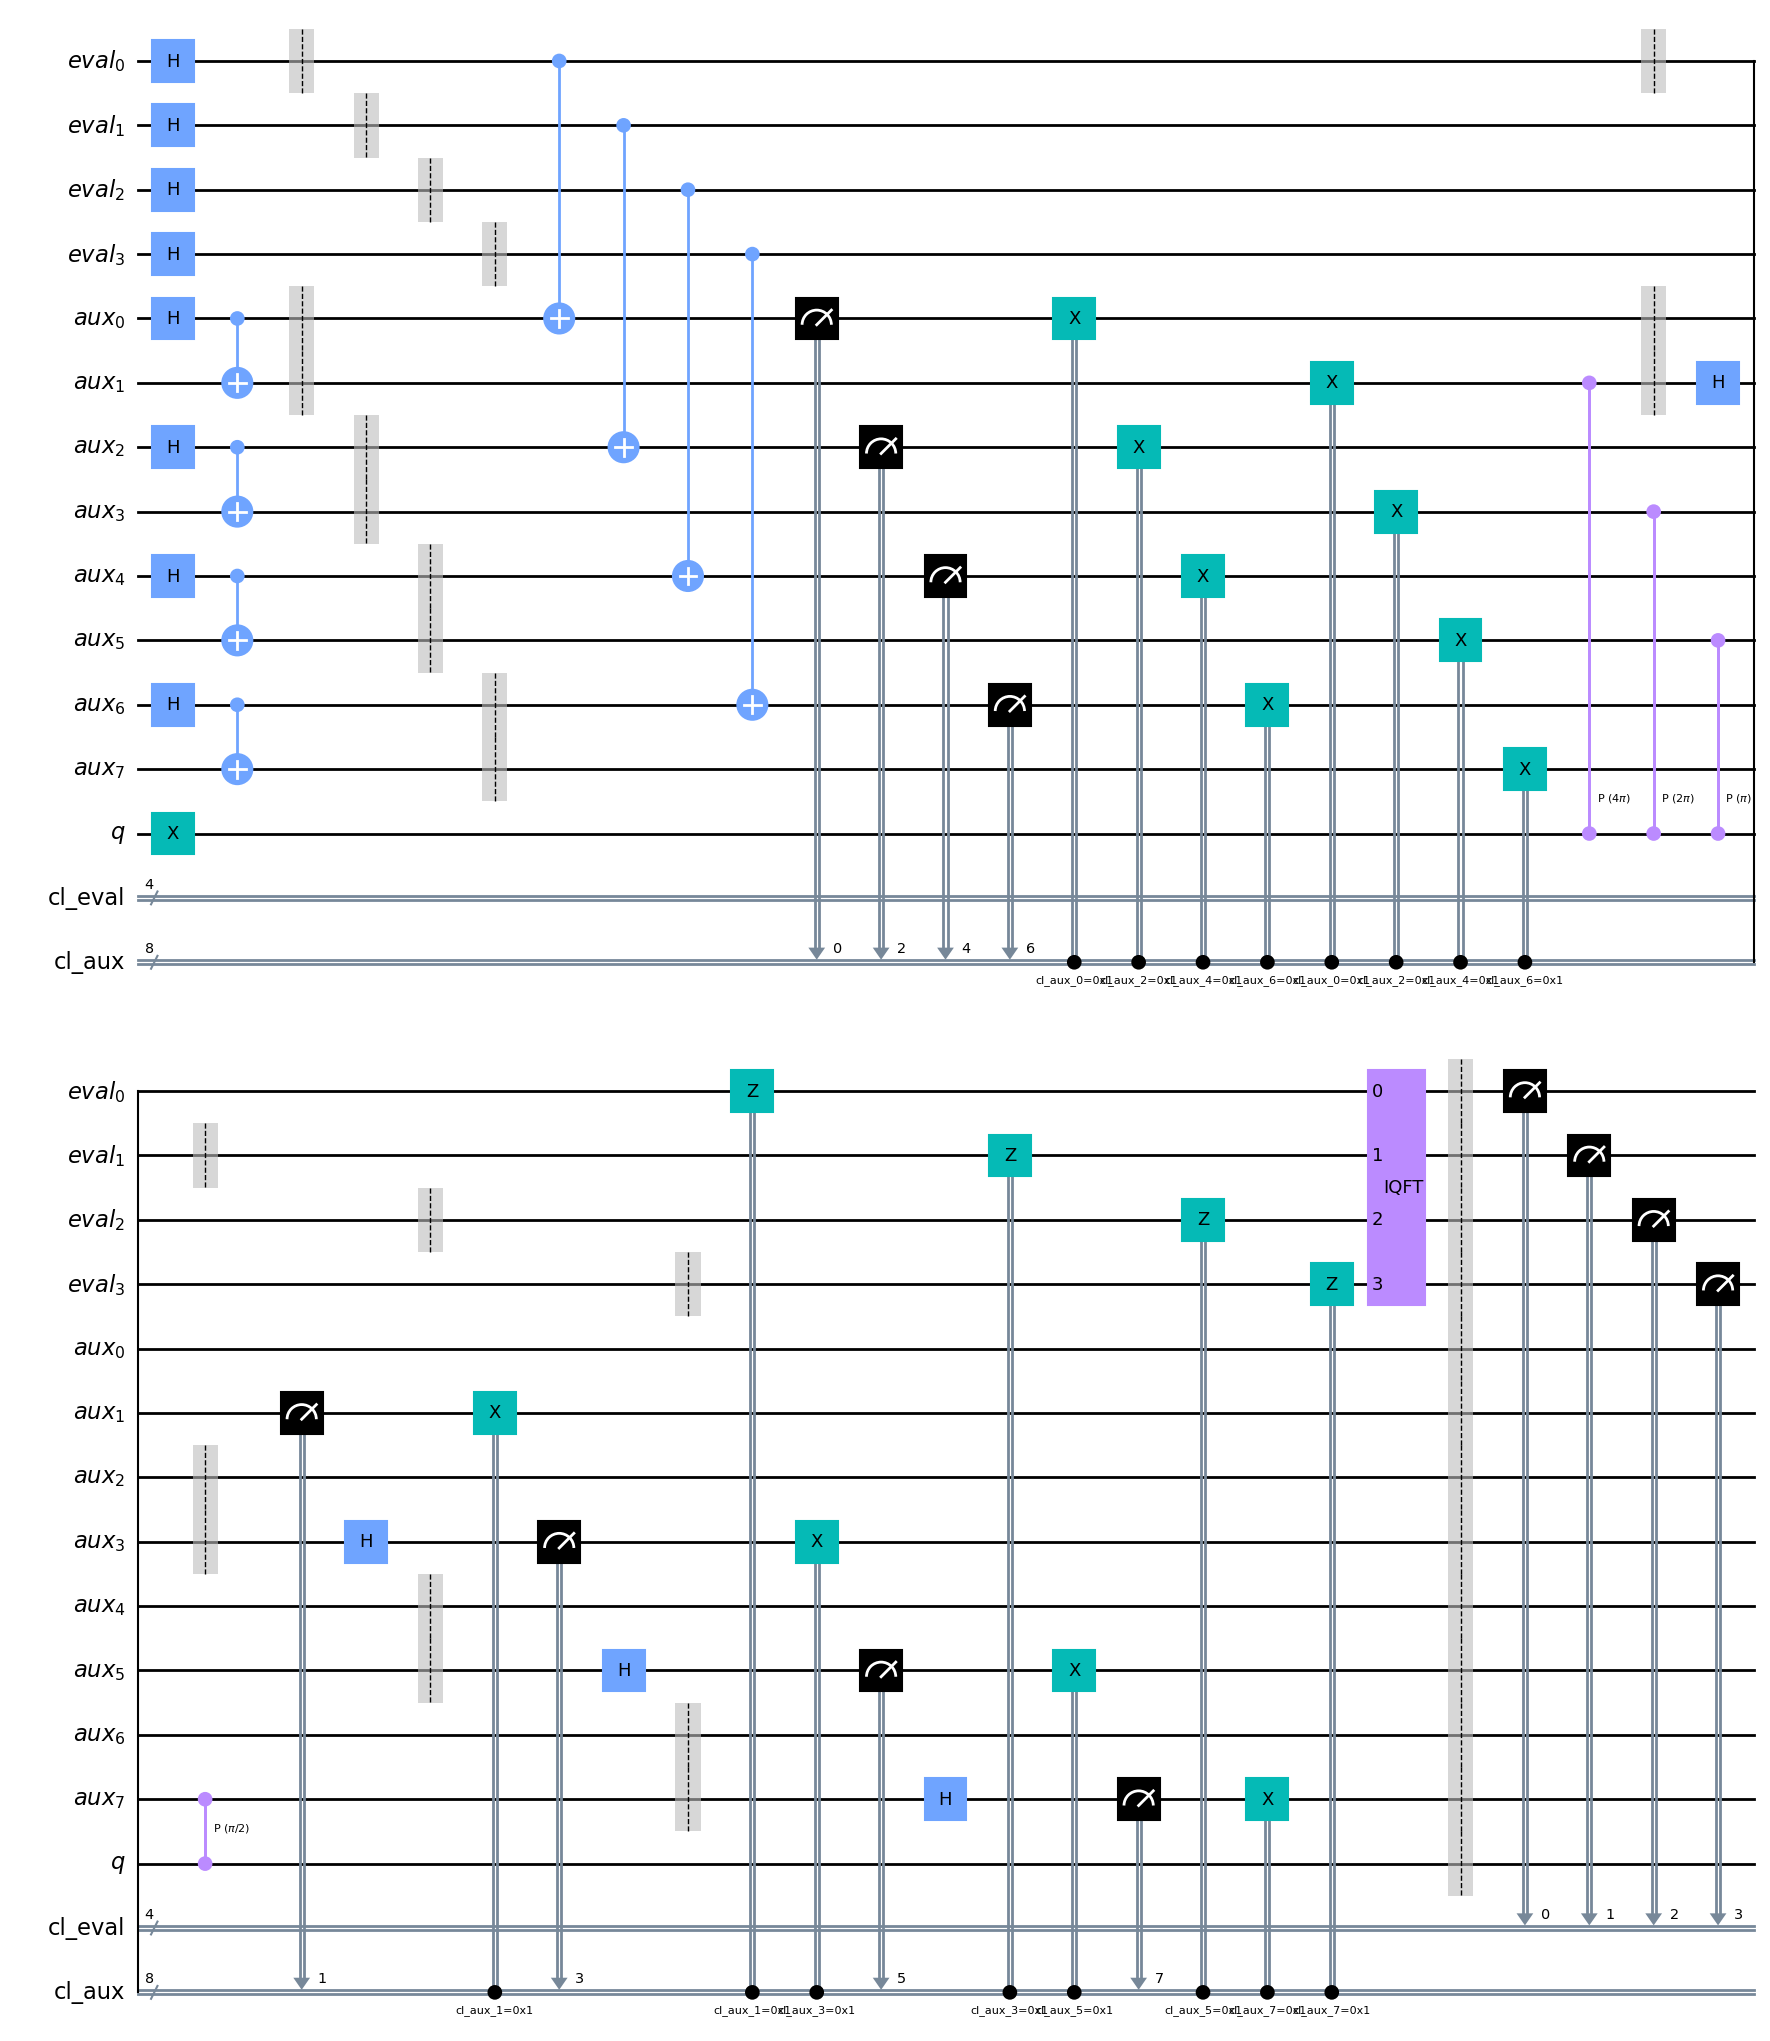

In [9]:
def qpe_distributed(gate: Gate = PhaseGate, psi: np.ndarray=[0,1], n_eval: int=4, param: float=0, measurements: bool = True):
    """Distributed implementation using cat entangler and cat disantangler."""

    # Definition of the registers and the circuit (3n + 1 qubits)
    qr_eval = QuantumRegister(n_eval, "eval")
    qr_aux = QuantumRegister(2*n_eval, "aux")
    qr_state = QuantumRegister(1, "q")
    cl_eval = ClassicalRegister(n_eval, "cl_eval")
    cl_aux = ClassicalRegister(2*n_eval, "cl_aux")

    qr_list = [qr_eval, qr_aux, qr_state]
    cl_list = [cl_eval, cl_aux]
    qpe = QuantumCircuit(*qr_list, *cl_list, name="QPE")

    # Declaration of the gates
    qpe.x(qr_state[0])
    qpe.h(qr_eval)

    cat_ent = cat_entangler()
    cat_dis = cat_disentangler()

    for j in range(n_eval):
        qubits_list = [qr_eval[j], qr_aux[2*j], qr_aux[2*j + 1]]
        qpe.compose(cat_ent, qubits=qubits_list, clbits=[cl_aux[2*j]], inplace=True)
        qpe.append(PhaseGate(theta = param).power(2**(n_eval-j-1)).control(), qargs=[qr_aux[2*j + 1]] + qr_state[:])
        qpe.compose(cat_dis, qubits=qubits_list, clbits=[cl_aux[2*j+1]], inplace=True)

    # Add the inverse QFT in both cases and measure the eval qubits  
    iqft = QFT(n_eval, inverse=True, do_swaps=False)  
    qpe.append(iqft, qargs=qr_eval)
    qpe.barrier()
    if measurements:
        for n in range(n_eval):
            qpe.measure(qr_eval[n],cl_eval[n])

    return qpe

n_eval = 4
phase_input = 0.25
qpe_distr = qpe_distributed(PhaseGate, n_eval=4, param=2*math.pi*phase_input)

qpe_distr.draw("mpl")

## Characterize the circuit <a class="anchor" id="apartado2"></a>

In [ ]:
print("The width of the circuit is: {}".format(qpe_distr.width()))
print("The size of the circuit is: {}".format(qpe_distr.size()))
print("The depth of the circuit is: {}".format(qpe_distr.depth()))

In [ ]:
qpe_distr_decomposed = qpe_distr.decompose(reps=9)
qpe_distr_decomposed.draw("mpl")

In [ ]:
print("The width of the circuit is: {}".format(qpe_distr_decomposed.width()))
print("The size of the circuit is: {}".format(qpe_distr_decomposed.size()))
print("The depth of the circuit is: {}".format(qpe_distr_decomposed.depth()))

## Run the circuit <a class="anchor" id="apartado3"></a>

In [10]:
def _process_answer(counts: dict) -> dict:
    """Auxiliar funtion to process the counts and erase the intermediate measures from the result.
    Args:
        counts: Result from the measurements of the quantum circuit.
    Returns:
        dict: Dictionary with the significant measures.
    """
    new_dict = {}
    for key, count in counts.items():
        keys = key.split()
        if len(keys) < 2:
            return
        new_key = keys[1]
        if new_key in new_dict:
            new_dict[new_key] = new_dict[new_key] + count
        else:
            new_dict[new_key] = count
    return new_dict

def execute_measurements(circuit: QuantumCircuit, simulator: str = "aer_simulator"):
    sim = Aer.get_backend(simulator)
    results = sim.run(transpile(circuit, sim)).result()

    return results

def get_phase(counts: dict, n_eval: int = 4, filter_counts: bool = False):
    
    if filter_counts:
        counts = _process_answer(counts=counts)

    evaluation = BitArray(bin = max(counts, key=counts.get)).int

    return evaluation/math.pow(2, n_eval)

In [11]:
phase_input = 0.25
qpe_distr = qpe_distributed(PhaseGate, param=2*math.pi*phase_input)

# Simulation of the circuit
results = execute_measurements(qpe_distr, "qasm_simulator")
counts = results.get_counts()

# Post process of the results
phase = get_phase(counts, filter_counts=True)

print("\n··· Results after postprocessing ···")
print("The value of the phase is: {phase:.{n_eval}f}".format(phase=phase, n_eval=4))


··· Results after postprocessing ···
The value of the phase is: 0.2500


In [12]:
phase_input = 0.333
qpe_distr = qpe_distributed(PhaseGate, param=2*math.pi*phase_input)

# Simulation of the circuit
results = execute_measurements(qpe_distr, "qasm_simulator")
counts = results.get_counts()

# Post process of the results
phase = get_phase(counts, filter_counts=True)

print("\n··· Results after postprocessing ···")
print("The value of the phase is: {phase:.{n_eval}f}".format(phase=phase, n_eval=4))


··· Results after postprocessing ···
The value of the phase is: 0.3125


In [13]:
phase_input = 0.25
qpe_circuit = qpe(param = 2*math.pi*phase_input, measurements=False)

# Simulation of the circuit
results = execute_measurements(qpe_circuit, "statevector_simulator")
psi = results.get_statevector(qpe_circuit)

psi.draw("latex")

<IPython.core.display.Latex object>

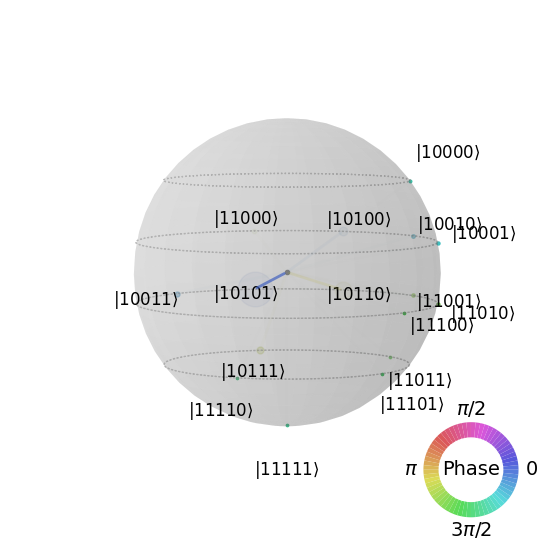

In [17]:
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_state_city, plot_state_qsphere

phase_input = 0.333
qpe_circuit = qpe(param = 2*math.pi*phase_input, measurements=False)

# Simulation of the circuit
results = execute_measurements(qpe_circuit, "statevector_simulator")
psi = results.get_statevector(qpe_circuit)

plot_state_qsphere(psi)

## Export/import the circuit <a class="anchor" id="apartado4"></a>

In [18]:
phase_input = 0.25
qpe_circuit = qpe(param = 2*math.pi*phase_input)
qasm_str = qpe_circuit.qasm()

print(qasm_str)

OPENQASM 2.0;
include "qelib1.inc";
gate gate_IQFT_dg q0,q1,q2,q3 { h q0; cp(-pi/2) q1,q0; h q1; cp(-pi/4) q2,q0; cp(-pi/2) q2,q1; h q2; cp(-pi/8) q3,q0; cp(-pi/4) q3,q1; cp(-pi/2) q3,q2; h q3; }
gate gate_IQFT q0,q1,q2,q3 { gate_IQFT_dg q0,q1,q2,q3; }
qreg eval[4];
qreg q[1];
creg cl_eval[4];
x q[0];
h eval[0];
h eval[1];
h eval[2];
h eval[3];
cp(4*pi) eval[0],q[0];
cp(2*pi) eval[1],q[0];
cp(pi) eval[2],q[0];
cp(pi/2) eval[3],q[0];
gate_IQFT eval[0],eval[1],eval[2],eval[3];
barrier eval[0],eval[1],eval[2],eval[3],q[0];
measure eval[0] -> cl_eval[0];
measure eval[1] -> cl_eval[1];
measure eval[2] -> cl_eval[2];
measure eval[3] -> cl_eval[3];



/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


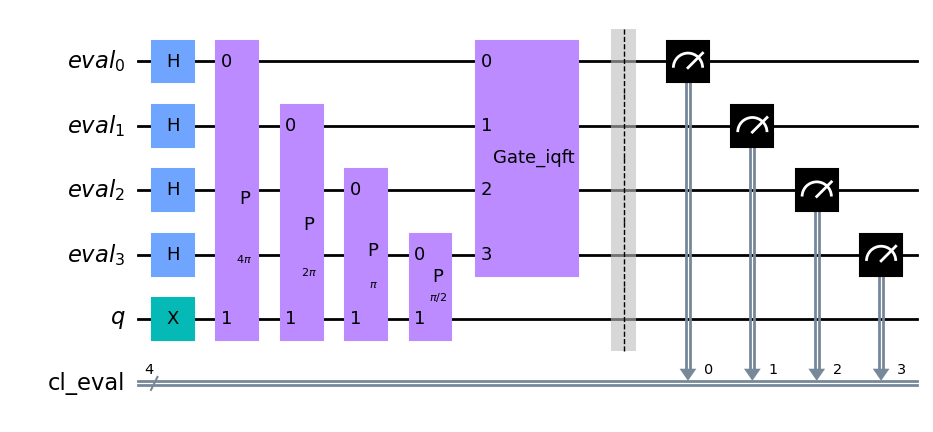

In [20]:
from qiskit.qasm2 import loads, CustomInstruction
customs = [
    CustomInstruction(name="cp", num_params=1, num_qubits=2, constructor=PhaseGate, builtin=True),
]

qpe_circuit_qasm = loads(qasm_str, custom_instructions=customs)
qpe_circuit_qasm.draw("mpl")

In [22]:
# Simulation of the circuit
results = execute_measurements(qpe_circuit_qasm, "qasm_simulator")
counts = results.get_counts()

# Post process of the results
phase = get_phase(counts)

print("\n··· Results after postprocessing ···")
print("The value of the phase is: {phase:.{n_eval}f}".format(phase=phase, n_eval=4))


··· Results after postprocessing ···
The value of the phase is: 0.2500
